In [1]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import altair as alt
from altair import datum
from tqdm.auto import tqdm, trange

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn, alt]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.0
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2
  altair: 4.1.0


# EDA

Let's start by loading our files.

In [2]:
# load all csvs
import zipfile
with zipfile.ZipFile(os.path.join(RAW_DATA_DIR, 'competitive-data-science-predict-future-sales.zip'), 'r') as datasets_file:
    item_categories = pd.read_csv(datasets_file.open('item_categories.csv'))
    items = pd.read_csv(datasets_file.open('items.csv'))
    sales_train = pd.read_csv(datasets_file.open('sales_train.csv'))
    shops = pd.read_csv(datasets_file.open('shops.csv'))

sales_train_by_month = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'sales-train-by-month.parquet'))
train_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set.parquet'))

# Item category metadata

I want to check what kind of features I can extract here that don't depend on time.

In [3]:
item_categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [4]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


We can see the category name carries some useful info. By translating them, we can see the first lines are accessories for gaming consoles and PCs (headsets and headphones in the PC case). We should be able to extract some interesting things from here. Let's check if the pattern is consistent by splitting everything on the dash (`-`).

In [5]:
split_category_names = item_categories['item_category_name'].str.split(pat='-', expand=True)
split_category_names

,0,1,2
0,PC,Гарнитуры/Наушники,None
1,Аксессуары,PS2,None
2,Аксессуары,PS3,None
3,Аксессуары,PS4,None
4,Аксессуары,PSP,None
...,...,...,...
79,Служебные,None,None
80,Служебные,Билеты,None
81,Чистые носители (шпиль),None,None
82,Чистые носители (штучные),None,None


In [6]:
split_category_names.describe()

,0,1,2
count,84,77,3
unique,21,58,3
top,Книги,Цифра,Ray
freq,13,4,1


We can see most of them have at least one dash and the first element is the one that varies the least. Let's check the examples that are split three times, which seem to be the rarest.

In [7]:
split_category_names[~split_category_names[2].isna()]

,0,1,2
37,Кино,Blu,Ray
38,Кино,Blu,Ray 3D
39,Кино,Blu,Ray 4K


All of them are different "blu ray" types, so we can just join the last column. Let's now look at the examples that have no dashes.

In [8]:
split_category_names[split_category_names[1].isna()]

,0,1,2
8,Билеты (Цифра),None,None
9,Доставка товара,None,None
32,"Карты оплаты (Кино, Музыка, Игры)",None,None
79,Служебные,None,None
81,Чистые носители (шпиль),None,None
82,Чистые носители (штучные),None,None
83,Элементы питания,None,None


Let's translate them so we can understand it better. From google translate, we got:
- Tickets (Number)
- Delivery of goods
- Payment cards (Cinema, Music, Games)
- Service
- Blank media (spire)
- Blank media (piece)
- Batteries

Which seem quite random. We'll call them "other" and group them in a single category.

We can now call the first column the major category and the second column a subcategory, from the frequencies we observed.

In [9]:
item_categories2 = item_categories['item_category_name'].str.split(pat='-', expand=True, n=1).rename(columns={0: "category_name", 1: "subcategory_name"})
item_categories2['item_category_id'] = item_categories['item_category_id'] 
item_categories2

,category_name,subcategory_name,item_category_id
0,PC,Гарнитуры/Наушники,0
1,Аксессуары,PS2,1
2,Аксессуары,PS3,2
3,Аксессуары,PS4,3
4,Аксессуары,PSP,4
...,...,...,...
79,Служебные,None,79
80,Служебные,Билеты,80
81,Чистые носители (шпиль),None,81
82,Чистые носители (штучные),None,82


In [10]:
tmp_filter = item_categories2['subcategory_name'].isna()
item_categories2.loc[tmp_filter, 'subcategory_name'] =  item_categories2.loc[tmp_filter, 'category_name']
item_categories2.loc[tmp_filter, 'category_name'] = 'Other'

In [11]:
item_categories2.describe(include='all')

,category_name,subcategory_name,item_category_id
count,84,84,84.000000
unique,15,67,NaN
top,Книги,Цифра,NaN
freq,13,4,NaN
mean,NaN,NaN,41.500000
std,NaN,NaN,24.392622
min,NaN,NaN,0.000000
25%,NaN,NaN,20.750000
50%,NaN,NaN,41.500000
75%,NaN,NaN,62.250000


Now let's check the relationship with the training set. Let's merge the datasets and then plot some 2D histograms to see what we find.

In [12]:
item_categories_metadata = items[['item_id', 'item_category_id']] # table with relationship between item and category
item_categories_metadata = item_categories_metadata.merge(item_categories2, on='item_category_id')
item_categories_metadata.describe(include='all')

,item_id,item_category_id,category_name,subcategory_name
count,22170.00000,22170.000000,22170,22170
unique,NaN,NaN,15,67
top,NaN,NaN,Кино,DVD
freq,NaN,NaN,7464,5035
mean,11084.50000,46.290753,NaN,NaN
std,6400.07207,15.941486,NaN,NaN
min,0.00000,0.000000,NaN,NaN
25%,5542.25000,37.000000,NaN,NaN
50%,11084.50000,40.000000,NaN,NaN
75%,16626.75000,58.000000,NaN,NaN


In [13]:
sales_train_with_categories_metadata = sales_train_by_month.merge(item_categories_metadata, on='item_id')

Let's see the sales distributions for the original categories and the categories now. 

<AxesSubplot:xlabel='item_category_id'>

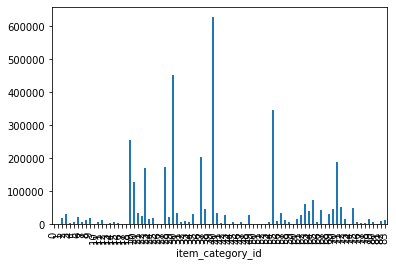

In [14]:
sales_train_with_categories_metadata.groupby(by='item_category_id')['item_cnt'].sum().plot.bar()

<AxesSubplot:xlabel='category_name'>

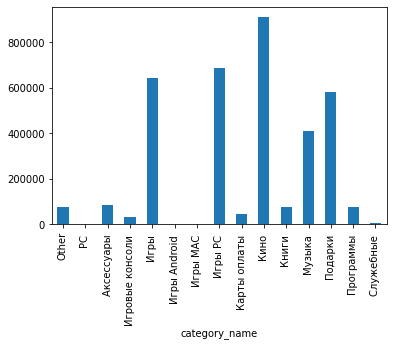

In [15]:
sales_train_with_categories_metadata.groupby(by='category_name')['item_cnt'].sum().plot.bar()

<AxesSubplot:xlabel='subcategory_name'>

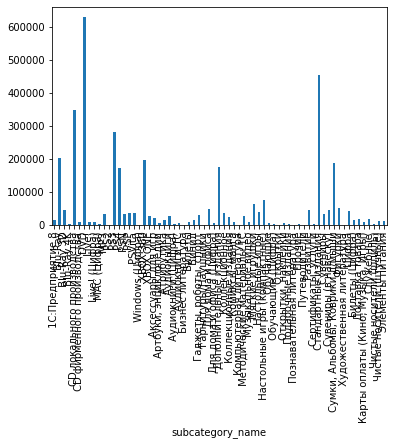

In [16]:
sales_train_with_categories_metadata.groupby(by='subcategory_name')['item_cnt'].sum().plot.bar()

We can encode these categories and subcategories and use them on our models.

## Shops

In [17]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


There are only two columns here. We could focus on the features we can extract from name, but I have another idea I want to test first. 

I want to be able to encode a shop in a way that similar shops are represented as close together, much like word2vec does. But here we can take advantage of domain knowledge: we can use which item categories are sold in each shop and see if we can encode shops using this. 

<AxesSubplot:xlabel='category_name', ylabel='shop_id'>

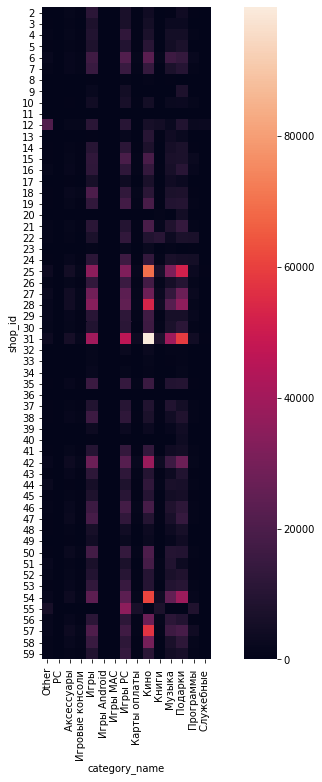

In [18]:
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data=sales_train_with_categories_metadata.pivot_table(index='shop_id', columns='category_name', aggfunc=np.sum, fill_value=0, values='item_cnt'),
            square=True, ax=ax)

It looks like we have some info here, but let's normalize the data to have a better look. We will do that by dividing each amount with the total sold in the shop, so we'll have a shop sales percentage as each value.

<AxesSubplot:xlabel='category_name', ylabel='shop_id'>

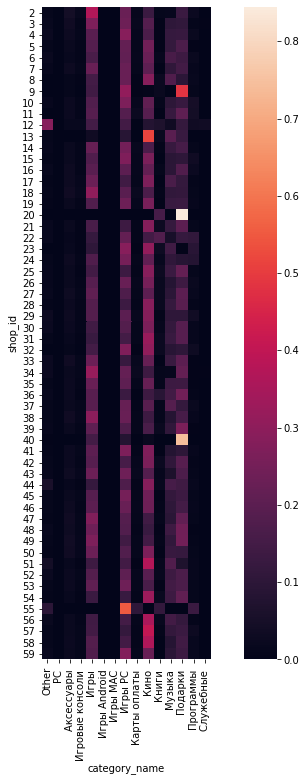

In [19]:
f, ax = plt.subplots(figsize=(12,12))
df_sales_cat_by_shop = sales_train_with_categories_metadata.pivot_table(index='shop_id', columns='category_name', aggfunc=np.sum, fill_value=0, values='item_cnt')
sns.heatmap(data=df_sales_cat_by_shop.div(df_sales_cat_by_shop.sum(axis=1), axis=0), square=True, ax=ax)

This looks promising. The only issue is that it's temporal data: we can't use it to generate vectors for our test set since we don't have that info (obviously). What I'll probably do is use the data from the previous month to generate encodings for the current month. We can plot the heatmap for each month and see how they change. 

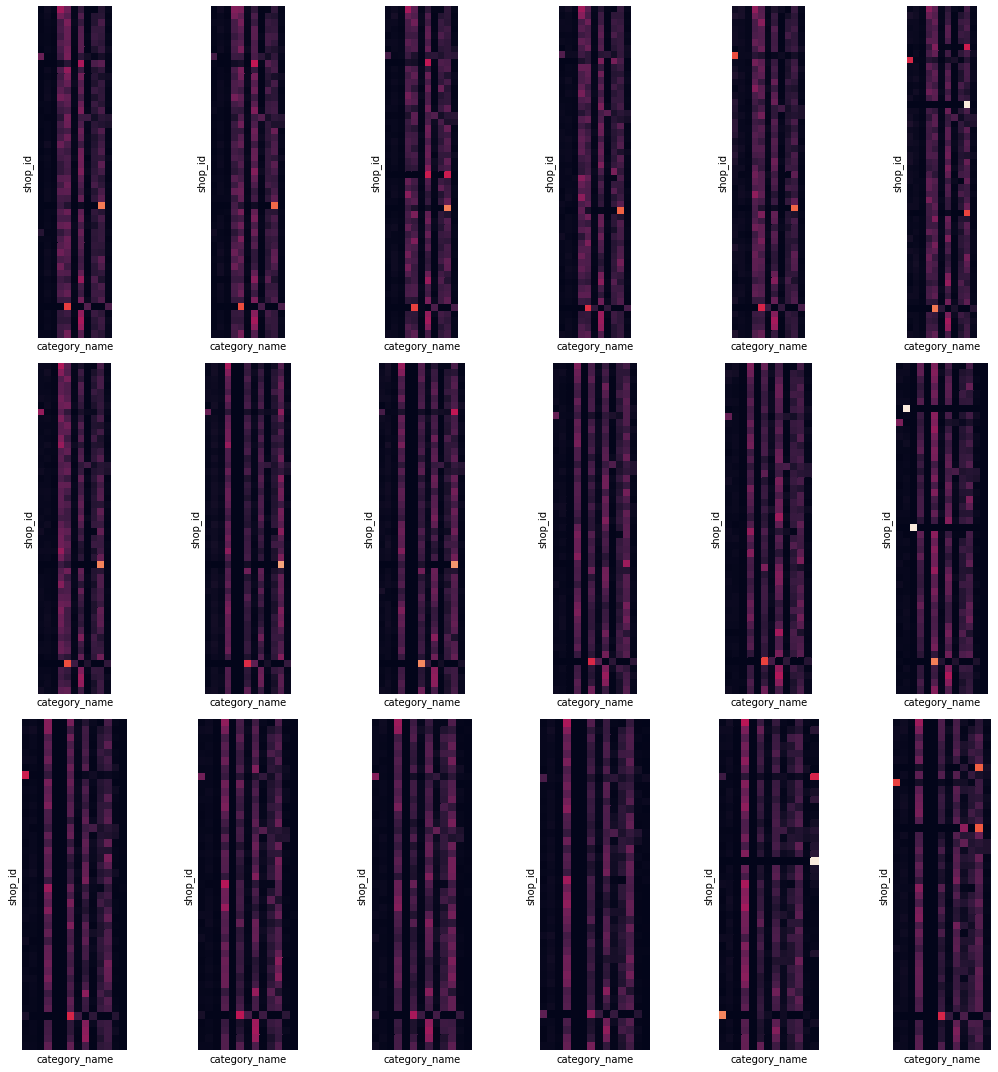

In [20]:
f, axes = plt.subplots(3, 6, figsize=(15,15))
for i in range(16, sales_train_by_month['date_block_num'].max() + 1):
    date_filter = sales_train_with_categories_metadata['date_block_num'] == i
    pivoted_df = sales_train_with_categories_metadata[date_filter].pivot_table(index='shop_id', columns='category_name', aggfunc=np.sum, fill_value=0, values='item_cnt')
    normalized_df = pivoted_df.div(pivoted_df.sum(axis=1), axis=0).fillna(0)
    ax = axes[(i - 16) // 6, (i - 16) % 6]
    sns.heatmap(data=normalized_df, square=True, ax=ax, cbar=False, xticklabels=False, yticklabels=False, vmin=0.0, vmax=1.0)
plt.tight_layout()

There seem to have no apparent consistency between months. Also some categories didn't exist before. It's also interesting to see how in some months a shop's activity is completely dominated by a single category.